# Демонстрация автоматического отбора признаков с помощью PrimarySelection

## Структура ноутбука:
- Применение библиотеки PrimarySelection для задач классификации
    * Приведение числовых признаков к типу float, замена бесконечных значений;
    * Проверка на пропущенные значения;
    * Корреляционный анализ;
    * Анализ признаков относительно глубины алгоритма;
    * Проверка всех библиотек Permutation Importance (sklearn, eli5, собственный kib) на CatBoostClassifier   

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, mean_absolute_percentage_error

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, NansAnalysis, PrimarySelection, base_pipe

* sklearn:  0.24.2
* xgboost:  1.5.2
* matplotlib:  3.1.1
* autobinary:  1.0.3

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab

print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

sklearn:  1.0.2
xgboost:  1.5.2
matplotlib:  3.5.1
autobinary:  1.0.6


In [5]:
import numpy as np
np.__version__

'1.21.5'

In [6]:
import scipy
scipy.__version__

'1.7.3'

In [7]:
# eli5==0.13.0

In [8]:
sample = pd.read_csv('../data/train_titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [9]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

features = num_columns+cat_columns

target = 'Survived'

In [10]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns
)

Определены количественные и категориальные переменные!


In [11]:
# обработка бесконечных и пропущенных значений

nans = NansAnalysis(df=sample)

sample = nans.to_types(num_columns=num_columns)
sample.head()

Все бесконечные значения заменены на пропуски, количественные переменные приведены к типу float!


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
# Проводим анализ на пропущенные значения. Столбцы имеющие пропусков больше percent.

feat_after_nans = nans.fit(percent = 0.9)

# Обновляем факторы

num_columns = list(filter(lambda x: x in feat_after_nans, num_columns))
cat_columns = list(filter(lambda x: x in feat_after_nans, cat_columns))

,feature,cnt_null,share_nans
10,Cabin,687,0.77
5,Age,177,0.20
11,Embarked,2,0.00
0,PassengerId,0,0.00
1,Survived,0,0.00


Количество столбцов до: 12
Удалены столбцы, имеющие долю пропусков > 90.0 %, количество оставшихся : 12 


In [13]:
# Функция nans_df - датафрейм с пропущенными значениями

nans.nans_df

,feature,cnt_null,share_nans
10,Cabin,687,0.77
5,Age,177,0.20
11,Embarked,2,0.00
0,PassengerId,0,0.00
1,Survived,0,0.00
2,Pclass,0,0.00
3,Name,0,0.00
4,Sex,0,0.00
6,SibSp,0,0.00
7,Parch,0,0.00


In [14]:
# Разделение на обучение и тест

X_train, X_valid, y_train, y_valid = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

# Использование класса PrimarySelection

### Класс PrimarySelection используется для анализа качества данных и отбора факторов.

* В параметры передаются тренировочная выборка, пайплайн обработки факторов, количественные и категориальные списки факторов, название таргета, тип модели и тип задачи.

In [15]:
# Инициализация класса первичного отбора факторов

feature_selection = PrimarySelection(df_train=X_train,
                                     base_pipe=base_pipe,
                                     num_columns=num_columns,
                                     cat_columns=cat_columns,
                                     target=target,
                                     model_type='lightboost',
                                     task_type='classification')

Класс первичного отбора факторов инициализирован!


## 1. Корреляционный анализ

* method - метод расчета корреляций (spearman / pearson);
* threshold - порог при котором фактор является коррелирующим;
* drop_with_most_correlations:
    * True - исключается фактор с наибольшим количеством коррелирующих с ним факторов с корреляцией выше порогового значения;
    * False - исключается фактор с наименьшим Джини из списка коррелирующих факторов.

In [16]:
# Корреляционный анализ 

feat_after_corr = feature_selection.corr_analysis(method='spearman',
                                                  threshold=0.4, 
                                                  drop_with_most_correlations=True)

Определены количественные и категориальные переменные!
Количество факторов до: 7
Количество факторов после корреляционного анализа: 6


In [17]:
# функция corr_df - датафрейм с коррелирующими факторами

feature_selection.corr_df

,Корреляция более 40.0%
Pclass,['Fare']


In [18]:
# функция metric_res - датафрейм с метриками однофакторного анализа

feature_selection.metric_res

,metric
Sex,54.1383
Fare,38.6561
Pclass,35.5899
Embarked,17.5231
Parch,17.3706
SibSp,17.2877
Age,2.5410


In [19]:
# Функция feat_after_corr - список факторов после корреляционного анализа

feature_selection.feat_after_corr

['Embarked', 'SibSp', 'Age', 'Parch', 'Fare', 'Sex']

## 2. Отбор признаков с помощью углубления древовидных алгоритмов

### Метод depth_analysis используется для отбора факторов относительно глубины алгоритма.

* В параметры передаются список факторов и максимальная глубина до которой будут расчитываться важности признаков.


* На выходе мы получаем таблицу из факторов отсортированных по важности, таблицу из факторов отрсортированных по рангу признака, список факторов из отсортированных по важности, список факторов из отсортированных по рангу.


    * Аргоритм отбора относительно глубины: модель обучается на всех факторах в цикле с глубиной от 1 до максимально указанной. Далее выводятся важности по каждому признаку в каждой глубине. После чего значение усредняется по каждому признаку и сортируется по убыванию.
    
    * Алгоритм отбора относительно ранга в глубине: аналогично предыдущему, только при каждом значении глубины отбираются признаки со значением важности >0, по ним расставляются ранговые значения, и расчитывается среднее внутри каждой глубины. После чего ранги усредняются относительно глубин и сортируются по убыванию.

In [20]:
# Анализ относительно глубины

depth_features, rank_features = feature_selection.depth_analysis(features=feat_after_corr,
                                                                 max_depth=3)

Определены количественные и категориальные переменные!


  0%|          | 0/3 [00:00<?, ?it/s]

Количество признаков до отбора: 6
Количество признаков после mean importance относительно глубины: 6
Количество признаков после mean rank относительно глубины: 6


,importance_depth_1,importance_depth_2,importance_depth_3,mean_importance,mean_rank
Sex,9248.759086,9802.779716,9991.386434,9680.975079,0.323810
Fare,2676.378949,3322.974358,4341.057824,3446.803711,0.258730
Age,0.000000,999.698651,1670.168675,889.955776,0.126984
SibSp,571.306269,770.071167,916.275160,752.550865,0.161905
Parch,0.000000,151.053780,525.644644,225.566141,0.063492


# 3. Проверка Permutation Importance на одной модели с разными алгоритмами sklearn, eli5, собственный код (kib)

    * Код является примером. Не обязательно использовать все три способа. Необходимо отталкиваться от размера выборки и типа задачи (классификация, мультикласс, регрессия). Для задач классификации наиболее оптимальными являются eli5 / kib. Для задач регрессии kib / sklearn.
    
    * Для начала применяем конвеер трансформации категориальных и численных признаков, после чего обучаем алгоритм при наших ранее заданных параметрах.

In [21]:
# Задаем стратегию деления больших данных для расчета permutation importance на подмножестве обучающего множества

strat = StratifiedKFold(n_splits=3,
                        shuffle=True,
                        random_state=42)

* На вход подаются список факторов после анализа относительно глубины / корреляционного анализа / анализа пропусков, стратегия деления, количество перемешиваний, тип перемешивания, число ядер, метрика и направление метрики (для типа перемешивания kib)

### 3.1 От Sklearn

In [22]:
feature_selection.permutation_analysis(features=depth_features,
                                       strat=strat,
                                       n_iter=10,
                                       permute_type='sklearn',
                                       n_jobs=-1,
 #                                      metric=roc_auc_score,
 #                                      higher_is_better=True
                                      )

Размер обучающего подмножества для Permutation importance: (415, 12) ; Среднее значение таргета: 0.38313253012048193

Размер тестового подмножества для Permutation importance: (208, 12) ; Среднее значение таргета: 0.38461538461538464
Определены количественные и категориальные переменные!


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
Sex,0.258554,0.220192
Fare,0.137590,0.048077
Age,0.071084,0.033654
random_feature,0.087229,0.011058
SibSp,0.015663,0.003846
Parch,0.014699,0.002404
Embarked,0.015904,-0.001923


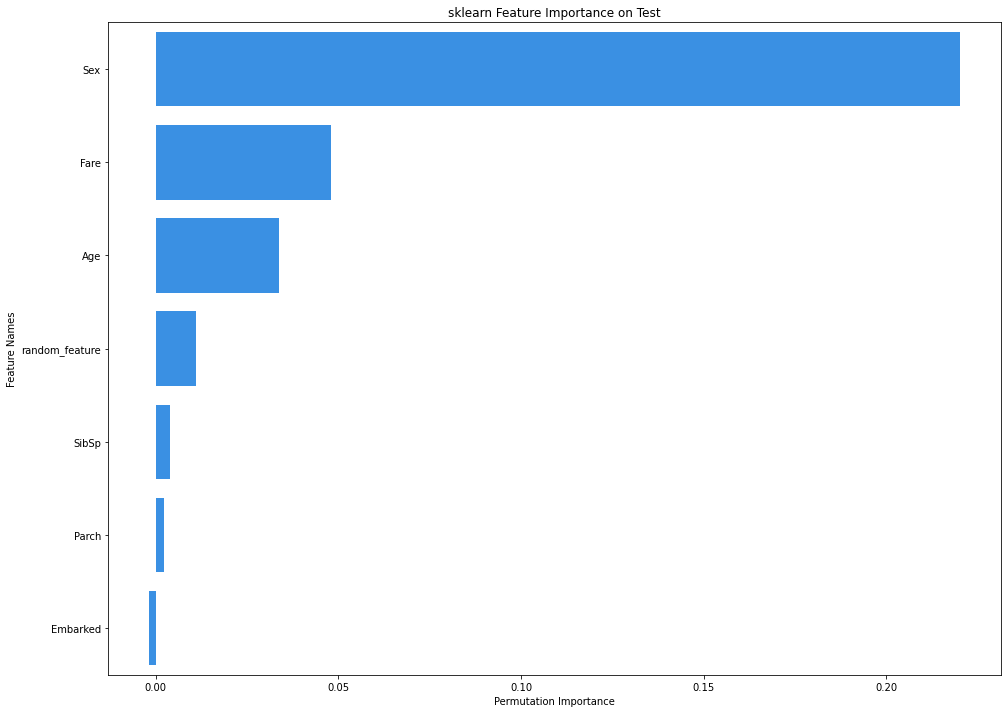

In [23]:
# вызов функции permutation_plot отрисовывает топ важности по методу permutation importance

feature_selection.permutation_plot(figsize=(16,12), top=10)

#### Вызов функции select_features выдает список отобранных признаков. 

* Отбор происходит следующим образом:
    * Если на тестовом множестве значение метрики относительно перемешанного факторо и рандомного признака ниже нуля, то отбираются все признаки выше нуля.
    * Если рандомный признак имеет положительное значение на тестовом множестве, то отбираются все признаки выше значения при рандомном признаке.

In [24]:
feature_selection.select_features()

7 признаков было до Permutation Importance 

3 признаков после Permutation Importance от sklearn


['Sex', 'Fare', 'Age']

### 3.2 От Eli5

In [25]:
feature_selection.permutation_analysis(features=depth_features,
                                       strat=strat,
                                       n_iter=10,
                                       permute_type='eli5',
 #                                      n_jobs=-1,
 #                                      metric=roc_auc_score,
 #                                      higher_is_better=True
                                      )

Размер обучающего подмножества для Permutation importance: (415, 12) ; Среднее значение таргета: 0.38313253012048193

Размер тестового подмножества для Permutation importance: (208, 12) ; Среднее значение таргета: 0.38461538461538464
Определены количественные и категориальные переменные!


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
Sex,0.248193,0.224038
Fare,0.138795,0.048558
Age,0.069880,0.033654
Parch,0.014458,0.006731
SibSp,0.018072,0.000481
Embarked,0.015663,-0.001442
random_feature,0.084337,-0.003365


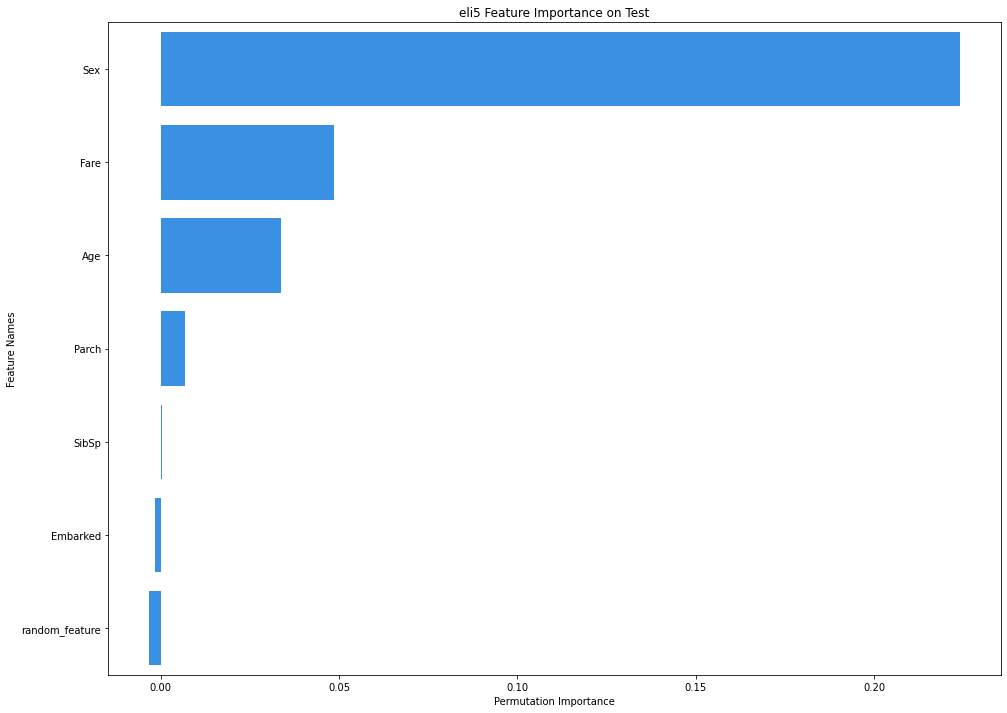

In [26]:
feature_selection.permutation_plot(figsize=(16,12), top=10)

In [27]:
feature_selection.select_features()

7 признаков было до Permutation Importance 

5 признаков после Permutation Importance от eli5


['Sex', 'Fare', 'Age', 'Parch', 'SibSp']

### 3.3 Самописный permutation kib

In [28]:
feature_selection.permutation_analysis(features=depth_features,
                                       strat=strat,
                                       n_iter=10,
                                       permute_type='kib',
                                       n_jobs=-1,
                                       metric=roc_auc_score,
                                       higher_is_better=True)

Размер обучающего подмножества для Permutation importance: (415, 12) ; Среднее значение таргета: 0.38313253012048193

Размер тестового подмножества для Permutation importance: (208, 12) ; Среднее значение таргета: 0.38461538461538464
Определены количественные и категориальные переменные!
Расчет Permutation Importance на Train


100%|██████████| 7/7 [00:00<00:00, 331.84it/s]


Расчет Permutation Importance на Test


100%|██████████| 7/7 [00:00<00:00, 2380.04it/s]


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
Sex,0.245923,0.233794
Fare,0.118239,0.075649
Age,0.043440,0.027095
Embarked,0.007707,0.005142
SibSp,0.005700,0.004229
random_feature,0.067355,0.001973
Parch,0.006641,-0.000176


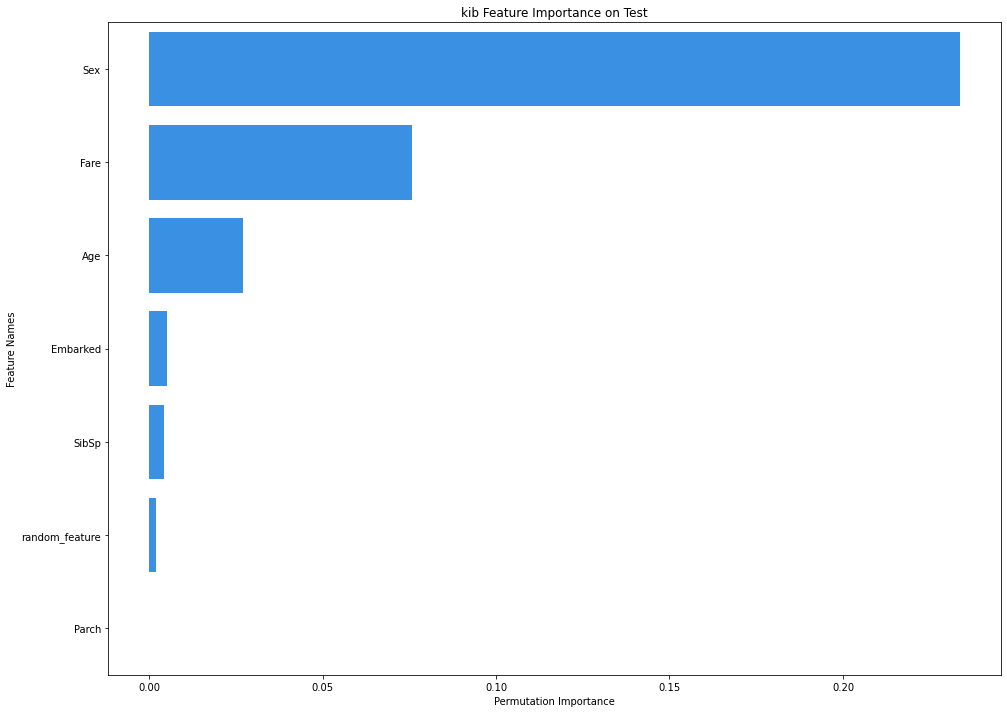

In [29]:
feature_selection.permutation_plot(figsize=(16,12), top=10)

In [30]:
feature_selection.select_features()

7 признаков было до Permutation Importance 

5 признаков после Permutation Importance от kib


['Sex', 'Fare', 'Age', 'Embarked', 'SibSp']